Caelan Osman

November 23, 2021

Math 437

Finite Element Analysis

In [1]:
import numpy as np
from scipy.linalg import solve_banded
from scipy import linalg
from matplotlib import pyplot as plt

We solve the problem

\begin{align*}
\varepsilon y^{\prime \prime} &- y^{\prime} = -1\\
y(0) = \alpha, &\quad y(1) = \beta
\end{align*}

where $\alpha = 2$, $\beta  =4$, and $\varepsilon = \frac1{50}$. Using $N=100$ finite elements (101 grid points).
We then compare our numerical solution with the analytic solution

\begin{align*}
    y(x) = \alpha + x + (\beta - \alpha - 1) \frac{e^{x /\varepsilon} -1}{e^{1/\varepsilon}-1}
\end{align*}

In [2]:
def FiniteElement( grid, alpha, beta, eps ):
    '''
    Performs finite element analysis on the heat equation
    :param grid: ( np.ndarray ) parameterized grid defining element domain
    :param alpha: ( float ) the minimum y value
    :param beta: ( float ) the maximum y value
    :param eps: ( float ) equation parameter
    :return K: ( np.ndarray ) basis coefficients
    '''
    #helper function to construct banded A matrix
    def a( i, j ):
        '''
        Integral evaluation to construct banded A matrix
        :param i: ( int ) basis function index
        :param j: ( int ) basis function index
        :return: ( float ) integral value
        '''
        if j == i + 1:
            hp1 = grid[ i + 1 ] - grid[ i ]
            return eps/hp1 + 1/2.
        elif j == i:
            h1 = grid[ i ] - grid[ i - 1 ]
            hp1 = grid[ i + 1 ] - grid[ i ]
            return -eps/h1 -eps/hp1
        elif j == i - 1:
            h1 = grid[ i ] - grid[ i - 1 ]
            return eps/h1 - 1/2.
        else:
            return 0
    #helper function to construct Phi vector
    def l( j ):
        '''
        Integral evluation to construc Phi vector
        :param j: ( int ) basis function index
        :return: ( float ) integral value
        '''
        h1 = grid[ j ] - grid[ j - 1 ]
        hp1 = grid[ j + 1 ] - grid[ j ]
        return -1*( h1 + hp1 ) / 2

    #construct Banded A matrix
    main_diag = np.ones_like( grid )
    main_diag[ 1:-1 ] = np.array([ a( i, i )
                                   for i in range( 1, grid.size - 1 ) ])

    sup_diag = np.zeros( grid.size )
    sup_diag[ 2: ] = np.array([ a( i + 1, i )
                                for i in range( 1, grid.size - 1 ) ])

    sub_diag = np.zeros( grid.size )
    sub_diag[ :-2 ] = np.array([ a( i, i + 1 )
                                 for i in range( 0, grid.size - 2 ) ])

    A_banded = np.vstack(( sup_diag, main_diag, sub_diag))
    #delete arrays to free up space
    del( main_diag, sup_diag, sub_diag )
    #construct Phi
    Phi = np.empty_like( grid )
    Phi[ 0 ] = alpha
    Phi[ -1 ] = beta

    Phi[ 1:-1 ] = np.array([ l( j )
                             for j in range( 1, grid.size - 1 ) ])

    #we can now use the banded matrix solver.
    return solve_banded( ( 1, 1 ), A_banded, Phi )


#basis function evaluation will use for plotting solution
def basis_eval( xs, grid, i ):
    '''
    Evaluates the ith basis function on the x values xs defined by the grid
    :param xs: ( np.ndarray ) The x values to evaluate the function at
    :param grid: ( np.ndarray ) element grid defining basis functions
    :param i: ( int ) index of basis function
    :return: ( np.ndarray ) basis function evaluation
    '''
    xs = np.atleast_1d( xs )
    partition = np.array([ ( x - grid[ i - 1 ] )/( grid[ i ] - grid[ i - 1 ] )
                           if ( i != 0 and grid[ i - 1 ] <= x and x <= grid[ i ] )
                           else ( grid[ i + 1 ] - x )/( grid[ i + 1 ] - grid[ i ] )
                           if ( grid[ i ] <= x and x <= grid[ i + 1 ] )
                           else 0 for x in xs ])
    return partition

#returns the numerical solution
def compute_num_sol( domain, grid, alpha, beta, eps ):
    '''
    Computes the numerical solution by performing FEA and then evaluates the basis
    using the coefficients as scaling factors
    :param domain: ( np.ndarray ) the domain to evaluate the basis on
    :param grid: ( np.ndarray ) the grid defining the basis functions
    :param alpha: ( float ) the minimum y value
    :param beta: ( float ) the minimum x value
    :param eps: ( float ) parameter value for the equation
    :return num_sol: ( np.ndarray ) the nmerical solution
    '''
    #gets the basis coefficients
    K = FiniteElement( grid, alpha, beta, eps )
    #returns the numerical solution array
    return np.array([ k * basis_eval( domain, grid, i ) for i, k in enumerate( K ) ]).sum( axis=0 )


#analytic solution function
def analytic_sol( x, a=2, b=4, eps=1/50. ):
    ''' Analytic solution for our PDE
    :param x: ( np.ndarray ) the evaluation point
    :param a: ( float ) minimum y value
    :param b: ( float ) maximum y value
    :param eps: ( float ) equation parameter
    :return eval: ( np.ndarray ) solution evaluation
    '''
    return a + x + ( b - a -1 ) * ( ( np.exp( x/eps ) - 1 )/( np.exp( 1/eps ) -1 ) )

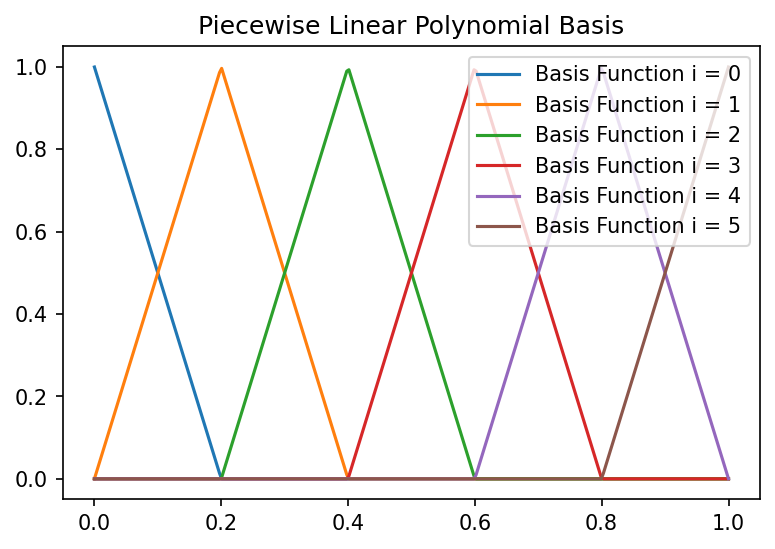

In [3]:
def test_basis():
    ''' Plots basis function
    '''
    grid = np.linspace( 0, 1, 6 )
    domain = np.linspace( 0, 1, 300 )
    fig = plt.figure()
    fig.set_dpi( 150 )
    ax = fig.add_subplot( 111 )
    for i in range( 6 ):
        ax.plot( domain, basis_eval( domain, grid, i ) , label='Basis Function i = ' + str( i ) )
        ax.legend( loc='best' )
        
    ax.set_title( 'Piecewise Linear Polynomial Basis' )
    plt.show()

    return
test_basis()

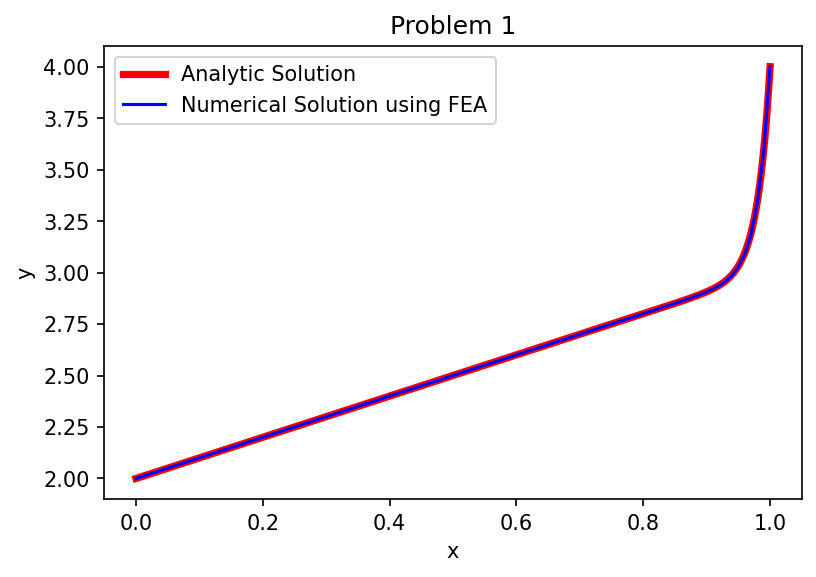

In [5]:
def problem1():
    '''
    Computes problem 1
    '''
    #set domain and grid
    domain = np.linspace( 0, 1, 1000 )
    grid = np.linspace( 0, 1, 101 )
    #get numerical solution
    alpha, beta, eps = 2, 4, 1/50.
    K = FiniteElement( grid, alpha, beta, eps )
    #num_sol = compute_num_sol( domain, grid, alpha, beta, eps )

    #plot analytic solution and numerical solution
    fig, ax = plt.subplots( 1, 1 )
    fig.set_dpi( 150 )
    ax.plot( domain, analytic_sol( domain ), 'r-', linewidth=3.5, label='Analytic Solution' )
    ax.plot( grid, K, 'b-', label='Numerical Solution using FEA' )
    ax.legend( loc='best' )
    ax.set_xlabel( 'x' )
    ax.set_ylabel( 'y' )
    ax.set_title( 'Problem 1' )
    plt.show()

    return

problem1()


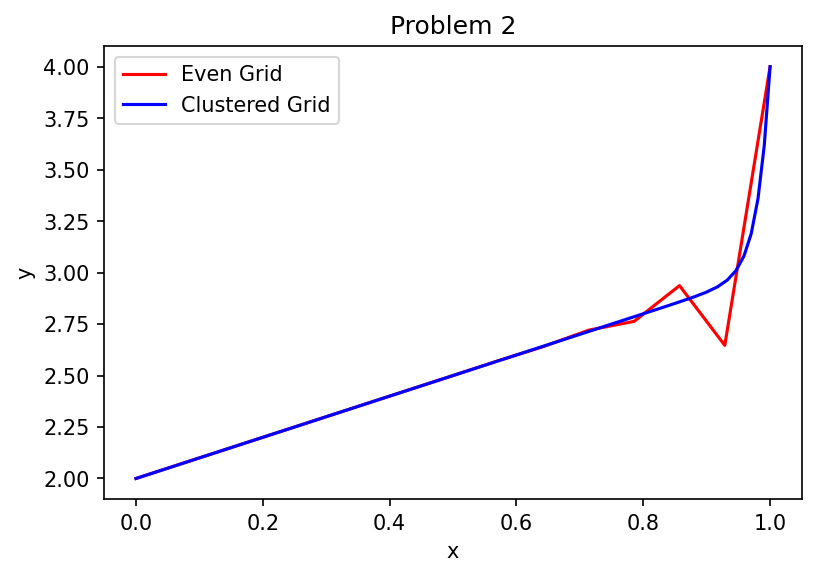

In [7]:
def problem2():
    '''
    Computes problem 2
    '''
    #set even and clustered grid
    even_grid = np.linspace( 0, 1, 15 )
    clustered_grid = np.linspace( 0, 1, 15 )**( 1/8. )
    #get numerical solution
    alpha, beta, eps = 2, 4, 1/50.
    #solve
    K_even = FiniteElement( even_grid, alpha, beta, eps )
    K_clustered = FiniteElement( clustered_grid, alpha, beta, eps )

    #now plot and compare
    fig = plt.figure()
    fig.set_dpi( 150 )
    ax = fig.add_subplot( 111 )
    ax.plot( even_grid,K_even, 'r-', label='Even Grid' )
    ax.plot( clustered_grid, K_clustered, 'b-', label='Clustered Grid' )
    ax.legend( loc='best' )
    ax.set_xlabel( 'x' )
    ax.set_ylabel( 'y' )
    ax.set_title( 'Problem 2' )
    return

problem2()

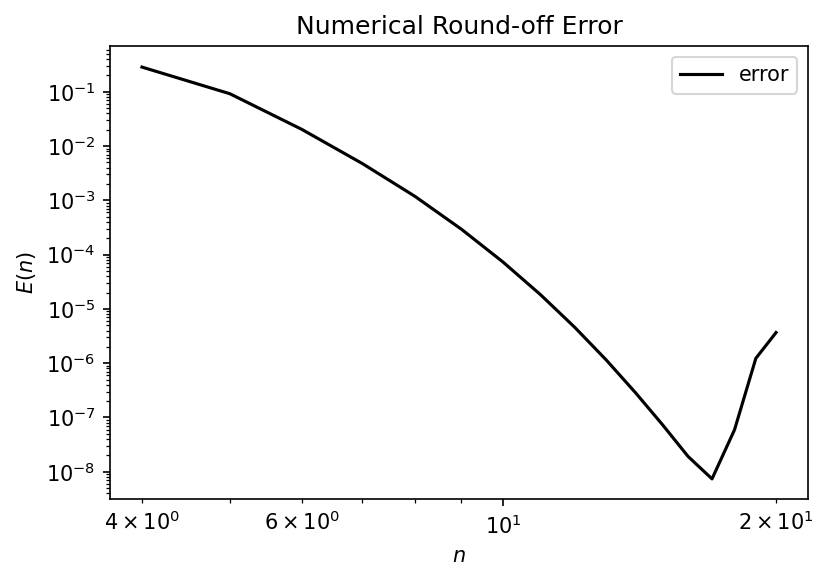

In [10]:
def problem3():
    '''
    computes problem 3
    '''
    alpha, beta, eps = 2, 4, 1/50.
    n_vals = np.arange( 4, 21 )
    Error = []
    for n in n_vals:
        grid = np.linspace( 0, 1, 2**n )
        curr_sol = FiniteElement( grid, alpha, beta, eps )
        true_sol = analytic_sol( grid )
        # compute_num_sol( domain, grid, alpha, beta, eps )
        curr_error = linalg.norm( curr_sol - true_sol, ord=np.inf )
        Error.append( curr_error )

    fig = plt.figure()
    fig.set_dpi( 150 )
    ax = fig.add_subplot( 111 )
    ax.loglog( n_vals, Error, 'k-', label='error' )
    ax.legend(loc='best')
    ax.set_ylabel( r'$E(n)$' )
    ax.set_xlabel( r'$n$' )
    ax.set_title( 'Numerical Round-off Error' )
    plt.show()

    return

problem3()